# WFM in de polikliniek
## Wachttijd omlaag, roosterstress omlaag (zonder de zorg te ‘callcenteriseren’)

**Doel:** inzichtelijk maken hoe vraagvariatie + consultduur + no-show + uitloop samen het rooster beïnvloeden, en welke *buffer-keuzes* het verschil maken.

**Niet het doel:** maximale bezettingsgraad. In zorg tellen voorspelbaarheid, werkbaarheid en kwaliteit even zwaar mee.

**Output-metrics (proxy’s):**
- Gemiddelde wachttijd in de wachtruimte (per dagdeel)
- % dagen met uitloop > 30 min
- Benutting per rol (arts, PA/VS)
- Rooster-werkbaarheid (proxy: aantal “overloop”-momenten)

In [ ]:
# --- 0) Imports & basis setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from datetime import datetime, timedelta

from IPython.display import display, Markdown

# Interactief (optioneel)
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False

np.random.seed(42)
plt.rcParams["figure.figsize"] = (10, 4)


ModuleNotFoundError: No module named 'numpy'

In [ ]:
# --- 1) Config / Aannames ---

@dataclass
class Config:
    start_date: str = "2025-09-01"
    days: int = 60  # simulatieperiode

    # Openingstijden
    open_hour: int = 8
    close_hour: int = 17  # exclusief
    slot_minutes: int = 5  # resolutie voor simulatie-grid

    # Afspraaktypen (minuten)
    appt_types = ("nieuw", "controle", "verrichting")
    mean_minutes = {"nieuw": 20, "controle": 15, "verrichting": 10}
    sd_minutes   = {"nieuw": 8,  "controle": 6,  "verrichting": 5}  # variatie + staart

    # Mix afspraaktypen (som = 1.0)
    mix = {"nieuw": 0.25, "controle": 0.60, "verrichting": 0.15}

    # Gedrag
    no_show_rate: float = 0.06     # 6%
    late_rate: float = 0.08        # 8% komt "te laat" (effect op wachttijd)
    late_minutes_mean: int = 7     # gemiddelde vertraging
    
    # Vraagpatroon (gem. aanvragen per uur) per dagdeel
    base_demand_per_hour: float = 5.0
    
    # Dag-van-week factoren (ma=0..zo=6)
    dow_factor = {0: 1.15, 1: 1.05, 2: 1.00, 3: 1.00, 4: 0.90, 5: 0.25, 6: 0.10}

    # Dagdeel factoren (ochtend piek)
    def hour_factor(self, hour: int) -> float:
        if 8 <= hour < 11: return 1.25
        if 11 <= hour < 14: return 1.00
        if 14 <= hour < 16: return 1.10
        if 16 <= hour < 17: return 0.85
        return 0.0

    # Capaciteit (providers)
    doctors: int = 2
    pas: int = 1  # PA/VS
    doctor_productive_ratio: float = 0.78  # tijd die echt consulttijd is (rest admin/overleg)
    pa_productive_ratio: float = 0.82

cfg = Config()
display(cfg)


Config(start_date='2025-09-01', days=60, open_hour=8, close_hour=17, slot_minutes=5, no_show_rate=0.06, late_rate=0.08, late_minutes_mean=7, base_demand_per_hour=5.0, doctors=2, pas=1, doctor_productive_ratio=0.78, pa_productive_ratio=0.82)

In [ ]:
# --- 2) Hulpfuncties: datums, verdelingen, vraag genereren ---

def date_range(start_date: str, days: int):
    start = pd.to_datetime(start_date)
    return [start + pd.Timedelta(days=i) for i in range(days)]

def clipped_normal(mean, sd, min_value=3):
    # consultduur: normale verdeling met ondergrens, plus lichte "staart"
    x = np.random.normal(mean, sd)
    # voeg af en toe lange consulten toe
    if np.random.rand() < 0.08:
        x *= np.random.uniform(1.3, 1.8)
    return max(min_value, x)

def generate_daily_arrivals(day: pd.Timestamp, cfg: Config) -> pd.DataFrame:
    """
    Genereert 'afspraakverzoeken' per 5-min slot (arrivals),
    met type-mix + consultduur.
    """
    dow = day.dayofweek
    rows = []
    for hour in range(cfg.open_hour, cfg.close_hour):
        lam = cfg.base_demand_per_hour * cfg.dow_factor[dow] * cfg.hour_factor(hour)
        # Poisson arrivals per uur
        n = np.random.poisson(lam=lam)
        for _ in range(n):
            minute = np.random.randint(0, 60)
            ts = day + pd.Timedelta(hours=hour, minutes=minute)

            # type kiezen volgens mix
            appt_type = np.random.choice(list(cfg.mix.keys()), p=list(cfg.mix.values()))
            dur = clipped_normal(cfg.mean_minutes[appt_type], cfg.sd_minutes[appt_type], min_value=5)

            # no-show
            no_show = np.random.rand() < cfg.no_show_rate

            # late
            late = np.random.rand() < cfg.late_rate
            late_min = int(max(0, np.random.normal(cfg.late_minutes_mean, 4))) if late else 0

            rows.append({
                "request_time": ts,
                "appt_type": appt_type,
                "planned_minutes": round(dur),
                "no_show": no_show,
                "late_minutes": late_min,
                "day": day.date(),
                "dow": dow,
                "hour": ts.hour
            })
    df = pd.DataFrame(rows).sort_values("request_time").reset_index(drop=True)
    return df


In [ ]:
# --- 3) Simuleer periode: vraagdata (afspraakverzoeken) ---
all_days = date_range(cfg.start_date, cfg.days)
requests = pd.concat([generate_daily_arrivals(day, cfg) for day in all_days], ignore_index=True)

# requests.head(), requests.shape
display(requests.head())
display(requests.shape)

,request_time,appt_type,planned_minutes,no_show,late_minutes,day,dow,hour
0,2025-09-01 08:17:00,verrichting,12,False,0,2025-09-01,0,8
1,2025-09-01 08:23:00,controle,29,False,3,2025-09-01,0,8
2,2025-09-01 08:41:00,nieuw,5,False,0,2025-09-01,0,8
3,2025-09-01 08:50:00,controle,15,False,0,2025-09-01,0,8
4,2025-09-01 08:52:00,nieuw,26,False,0,2025-09-01,0,8


(2397, 8)

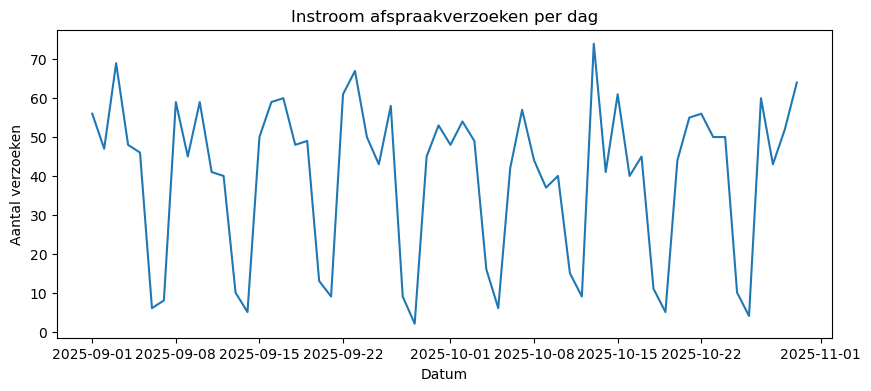

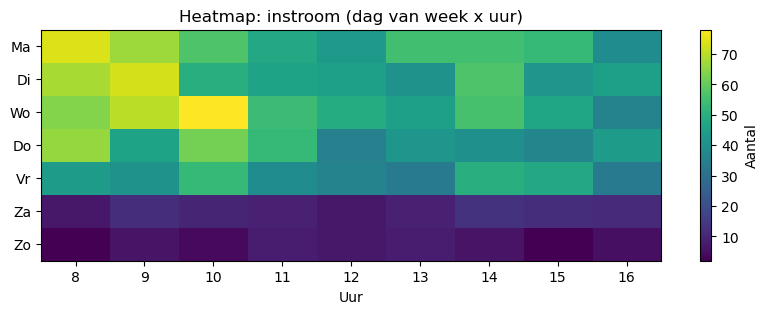

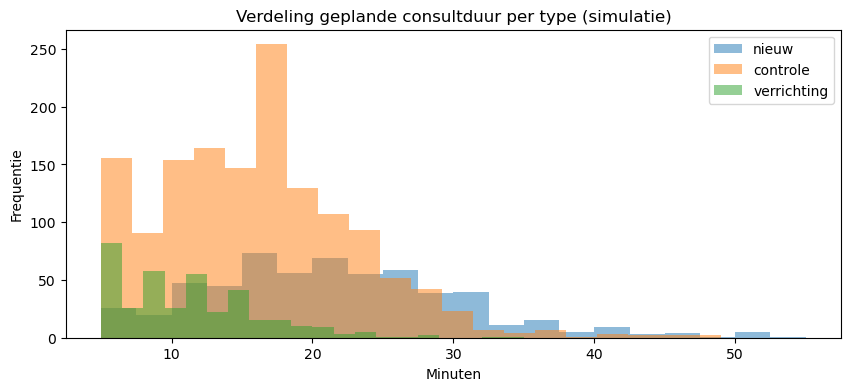

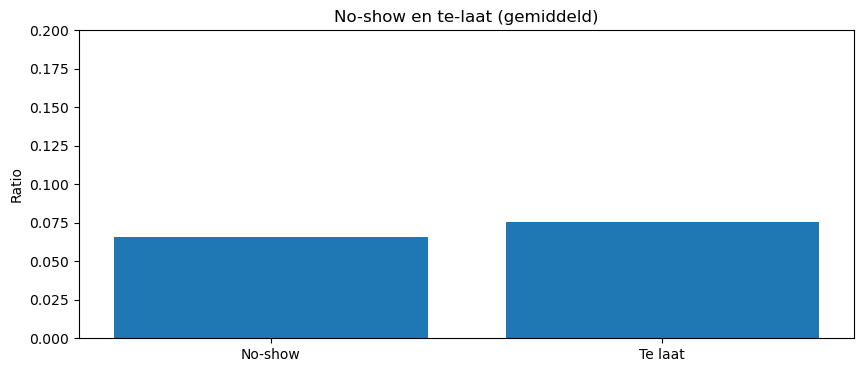

In [ ]:
# --- 4) Vraaganalyse: grafieken ---

# A) Instroom per dag
daily_counts = requests.groupby("day").size().rename("requests").reset_index()
plt.figure()
plt.plot(pd.to_datetime(daily_counts["day"]), daily_counts["requests"])
plt.title("Instroom afspraakverzoeken per dag")
plt.xlabel("Datum")
plt.ylabel("Aantal verzoeken")
plt.show()

# B) Heatmap dag-van-week x uur
pivot = requests.pivot_table(index="dow", columns="hour", values="appt_type", aggfunc="count").fillna(0)
plt.figure(figsize=(10, 3))
plt.imshow(pivot.values, aspect="auto")
plt.title("Heatmap: instroom (dag van week x uur)")
plt.yticks(range(7), ["Ma","Di","Wo","Do","Vr","Za","Zo"])
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.xlabel("Uur")
plt.colorbar(label="Aantal")
plt.show()

# C) Verdeling consultduur per type
plt.figure()
for t in cfg.appt_types:
    x = requests.loc[requests["appt_type"]==t, "planned_minutes"].values
    plt.hist(x, bins=20, alpha=0.5, label=t)
plt.title("Verdeling geplande consultduur per type (simulatie)")
plt.xlabel("Minuten")
plt.ylabel("Frequentie")
plt.legend()
plt.show()

# D) No-show en te-laat
plt.figure()
rates = pd.Series({
    "No-show": requests["no_show"].mean(),
    "Te laat": (requests["late_minutes"]>0).mean(),
})
plt.bar(rates.index, rates.values)
plt.title("No-show en te-laat (gemiddeld)")
plt.ylabel("Ratio")
plt.ylim(0, max(0.2, rates.max()*1.4))
plt.show()


In [ ]:
# --- 5) Forecast (simpel): gemiddelde per dow + uur, met bandbreedte ---

# Maak een tijdslotkolom per uur (forecast granulariteit: uur)
requests["date"] = pd.to_datetime(requests["day"])
requests["dow_name"] = requests["dow"].map({0:"Ma",1:"Di",2:"Wo",3:"Do",4:"Vr",5:"Za",6:"Zo"})

grp = requests.groupby(["dow", "hour"]).size().rename("count").reset_index()

# Gemiddelde en percentielen per (dow,hour) over de weken: benaderd door resampling per dag
hourly = requests.set_index("request_time").resample("h").size().rename("count").reset_index()
hourly["dow"] = hourly["request_time"].dt.dayofweek
hourly["hour"] = hourly["request_time"].dt.hour
hourly = hourly[(hourly["hour"]>=cfg.open_hour) & (hourly["hour"]<cfg.close_hour)]

stats = hourly.groupby(["dow","hour"])["count"].agg([
    ("p10", lambda s: np.quantile(s, 0.10)),
    ("p50", lambda s: np.quantile(s, 0.50)),
    ("p90", lambda s: np.quantile(s, 0.90)),
    ("mean", "mean"),
]).reset_index()

display(stats.head())


,dow,hour,p10,p50,p90,mean
0,0,8,6.0,8.0,10.4,8.222222
1,0,9,4.8,7.0,9.8,7.444444
2,0,10,3.8,6.0,8.4,6.333333
3,0,11,2.6,5.0,8.2,5.333333
4,0,12,3.6,4.0,7.2,4.777778


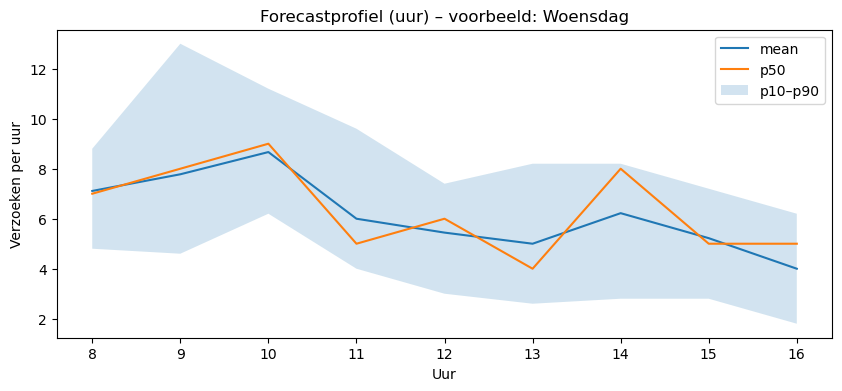

In [ ]:
# Visualiseer forecastprofiel voor één dag (bv woensdag = 2)
dow_pick = 2  # Wo
day_stats = stats[stats["dow"]==dow_pick].sort_values("hour")

plt.figure()
plt.plot(day_stats["hour"], day_stats["mean"], label="mean")
plt.plot(day_stats["hour"], day_stats["p50"], label="p50")
plt.fill_between(day_stats["hour"], day_stats["p10"], day_stats["p90"], alpha=0.2, label="p10–p90")
plt.title("Forecastprofiel (uur) – voorbeeld: Woensdag")
plt.xlabel("Uur")
plt.ylabel("Verzoeken per uur")
plt.legend()
plt.show()


In [ ]:
# --- 6) Van vraag naar benodigde consult-minuten (capacity model) ---

def expected_minutes_per_request(cfg: Config) -> float:
    # Verwachte consultduur o.b.v. mix (no-show telt niet mee als consultminuten)
    exp = 0.0
    for t, p in cfg.mix.items():
        exp += p * cfg.mean_minutes[t]
    # corrigeer voor no-show: minder uitgevoerde consulten
    return exp * (1 - cfg.no_show_rate)

def required_provider_minutes_per_hour(forecast_requests_per_hour: float, cfg: Config, buffer_ratio: float) -> float:
    base = forecast_requests_per_hour * expected_minutes_per_request(cfg)
    return base * (1 + buffer_ratio)

exp_min = expected_minutes_per_request(cfg)
display(exp_min)


14.569999999999999

In [ ]:
# Capaciteit per uur (productieve minuten)
def available_provider_minutes_per_hour(cfg: Config) -> dict:
    mins = 60.0
    return {
        "doctor": cfg.doctors * mins * cfg.doctor_productive_ratio,
        "pa": cfg.pas * mins * cfg.pa_productive_ratio,
        "total": (cfg.doctors * mins * cfg.doctor_productive_ratio) + (cfg.pas * mins * cfg.pa_productive_ratio),
    }

avail = available_provider_minutes_per_hour(cfg)
display(avail)


{'doctor': 93.60000000000001, 'pa': 49.199999999999996, 'total': 142.8}

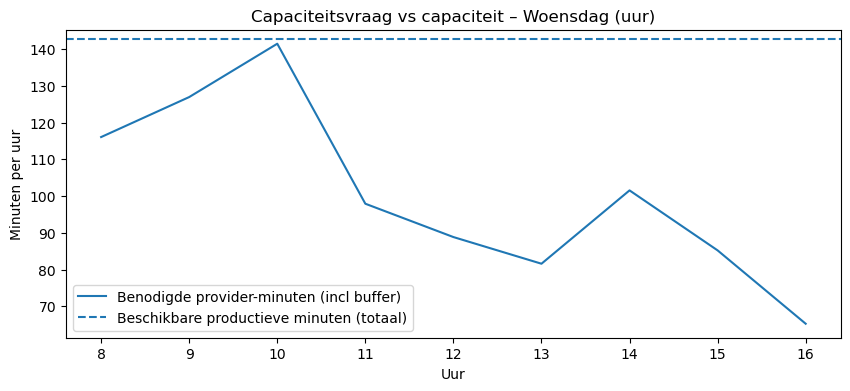

In [ ]:
# Plot: benodigde minuten vs beschikbare minuten (voorbeeld dag)
buffer_ratio = 0.12  # 12% werkbaar
day_stats = stats[stats["dow"]==dow_pick].sort_values("hour").copy()
day_stats["req_minutes"] = day_stats["mean"].apply(lambda x: required_provider_minutes_per_hour(x, cfg, buffer_ratio))

plt.figure()
plt.plot(day_stats["hour"], day_stats["req_minutes"], label="Benodigde provider-minuten (incl buffer)")
plt.axhline(avail["total"], linestyle="--", label="Beschikbare productieve minuten (totaal)")
plt.title("Capaciteitsvraag vs capaciteit – Woensdag (uur)")
plt.xlabel("Uur")
plt.ylabel("Minuten per uur")
plt.legend()
plt.show()


In [ ]:
# --- 7) Simpele "operational" simulatie: wachtrij / uitloop proxy ---

def simulate_day_queue(day_requests: pd.DataFrame, cfg: Config, buffer_ratio: float):
    """
    Vereenvoudigde simulatie:
    - Arrivals zijn request_time (+ late_minutes)
    - Service time = planned_minutes (no_show -> service=0)
    - Servers = total provider-minuten per minuut (vereenvoudigd: 1 pooled resource)
    
    Output:
    - avg_wait: gemiddelde wachttijd (min)
    - pct_overrun_30: indicator of dag eindigt > 30 min na sluiting
    - utilization: gebruikte minuten / beschikbare productieve minuten
    """
    # Build arrivals timeline
    df = day_requests.copy()
    df["arrival"] = df["request_time"] + pd.to_timedelta(df["late_minutes"], unit="m")
    df["service"] = np.where(df["no_show"], 0, df["planned_minutes"]).astype(float)

    # Werktijd window
    day = pd.to_datetime(df["day"].iloc[0])
    start = day + pd.Timedelta(hours=cfg.open_hour)
    end = day + pd.Timedelta(hours=cfg.close_hour)

    # Total available productive minutes per minute
    total_prod_per_hour = avail["total"]  # minutes per hour
    total_prod_per_min = total_prod_per_hour / 60.0
    # buffer betekent dat je effectief minder strak plant; we modelleren dat als "extra slack" -> iets lagere effectieve benutting target
    effective_capacity_per_min = total_prod_per_min / (1 + buffer_ratio)

    # Sorteer op arrival
    df = df.sort_values("arrival").reset_index(drop=True)

    # Single pooled queue simulation (approx)
    current_time = start
    backlog = 0.0  # minuten werk in wachtrij
    waits = []
    used_service = 0.0

    for _, r in df.iterrows():
        arr = r["arrival"]
        service = r["service"]

        if arr < start:
            arr = start

        # werk backlog af tussen current_time en arrival
        if arr > current_time:
            dt = (arr - current_time).total_seconds() / 60.0
            processed = dt * effective_capacity_per_min
            backlog = max(0.0, backlog - processed)
            current_time = arr

        # wachttijd = backlog / capaciteit per min
        wait = backlog / max(1e-6, effective_capacity_per_min)
        waits.append(wait)

        # voeg service toe aan backlog
        backlog += service
        used_service += service

    # werk backlog af tot na eindtijd
    current_time_end = end
    if current_time_end > current_time:
        dt = (current_time_end - current_time).total_seconds() / 60.0
        processed = dt * effective_capacity_per_min
        backlog = max(0.0, backlog - processed)
        current_time = current_time_end

    # als backlog > 0 => uitloop
    overrun_minutes = backlog / max(1e-6, effective_capacity_per_min)
    pct_overrun_30 = 1.0 if overrun_minutes > 30 else 0.0

    total_available = (cfg.close_hour - cfg.open_hour) * avail["total"]
    utilization = used_service / max(1e-6, total_available)

    return {
        "avg_wait": float(np.mean(waits) if waits else 0.0),
        "p95_wait": float(np.quantile(waits, 0.95) if waits else 0.0),
        "overrun_minutes": float(overrun_minutes),
        "overrun_30_flag": pct_overrun_30,
        "utilization": float(utilization),
        "n_requests": int(len(df)),
    }


In [ ]:
# Run simulatie over alle dagen voor 3 scenario's
def run_scenarios(requests: pd.DataFrame, cfg: Config, buffer_ratios: dict):
    out = []
    for day, df_day in requests.groupby("day"):
        for name, buf in buffer_ratios.items():
            res = simulate_day_queue(df_day, cfg, buf)
            res["day"] = day
            res["scenario"] = name
            res["buffer_ratio"] = buf
            out.append(res)
    return pd.DataFrame(out)

buffer_scenarios = {
    "A Strak": 0.05,
    "B Werkbaar": 0.12,
    "C Slimme piek-buffer": 0.15,  # later kun je dit verfijnen naar piek-only
}

scenario_results = run_scenarios(requests, cfg, buffer_scenarios)
display(scenario_results.head())


,avg_wait,p95_wait,overrun_minutes,overrun_30_flag,utilization,n_requests,day,scenario,buffer_ratio
0,9.347164,26.713235,0.000000,0.0,0.659041,56,2025-09-01,A Strak,0.05
1,12.694328,35.176471,0.000000,0.0,0.659041,56,2025-09-01,B Werkbaar,0.12
2,14.291116,39.496849,0.474790,0.0,0.659041,56,2025-09-01,C Slimme piek-buffer,0.15
3,6.851064,23.220588,14.558824,0.0,0.592904,47,2025-09-02,A Strak,0.05
4,8.041302,26.070588,19.529412,0.0,0.592904,47,2025-09-02,B Werkbaar,0.12


In [ ]:
# Visualisatie: wachttijd en uitloop per scenario
summary = scenario_results.groupby("scenario").agg(
    avg_wait=("avg_wait","mean"),
    p95_wait=("p95_wait","mean"),
    overrun_days=("overrun_30_flag","mean"),
    avg_overrun=("overrun_minutes","mean"),
    utilization=("utilization","mean"),
    n=("n_requests","mean")
).reset_index()

display(summary)


,scenario,avg_wait,p95_wait,overrun_days,avg_overrun,utilization,n
0,A Strak,5.888963,18.020270,0.033333,3.618137,0.477604,39.95
1,B Werkbaar,7.424375,21.445245,0.066667,4.871569,0.477604,39.95
2,C Slimme piek-buffer,8.163506,23.011422,0.066667,5.533824,0.477604,39.95


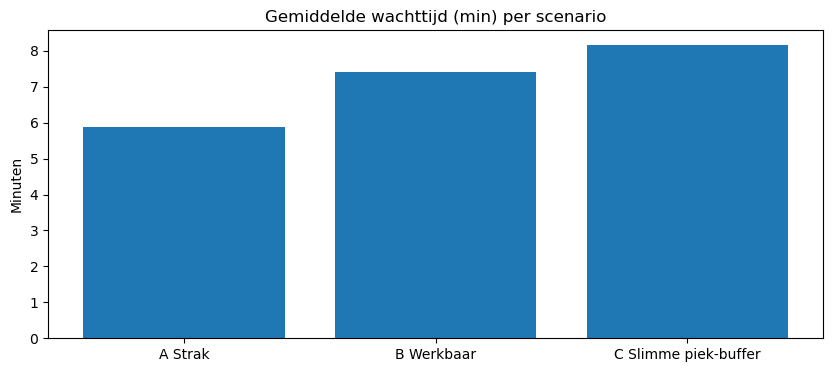

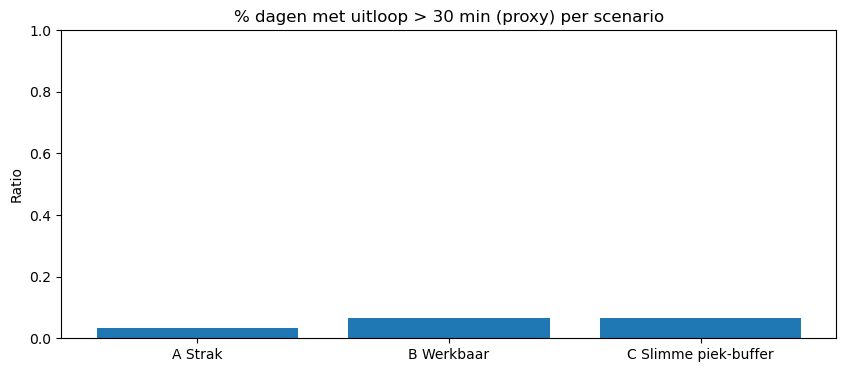

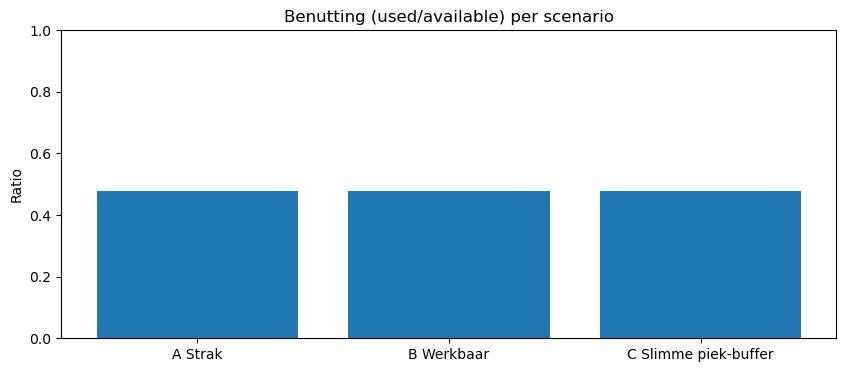

In [ ]:
plt.figure()
plt.bar(summary["scenario"], summary["avg_wait"])
plt.title("Gemiddelde wachttijd (min) per scenario")
plt.ylabel("Minuten")
plt.show()

plt.figure()
plt.bar(summary["scenario"], summary["overrun_days"])
plt.title("% dagen met uitloop > 30 min (proxy) per scenario")
plt.ylabel("Ratio")
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.bar(summary["scenario"], summary["utilization"])
plt.title("Benutting (used/available) per scenario")
plt.ylabel("Ratio")
plt.ylim(0, 1)
plt.show()


## 8) Aanbevelingen (concepttekst)

**Wat valt op?**
- Scenario A (strak) verlaagt de buffer, maar verhoogt het risico op uitloop en piek-stress.
- Scenario B (werkbaar) stabiliseert de dag: iets meer slack, minder “brandjes”.
- Scenario C (slimme buffer) zet ruimte waar de variatie zit (piekdagdelen).

**Praktische aanbevelingen voor de poli**
1. **Maak buffer expliciet en intentioneel** (niet “per ongeluk” aan het eind van de dag).
2. **Categoriseer afspraaktypen strakker** (duurklassen, herijking per arts/team).
3. **Borg voorspelbaarheid**: liever iets minder throughput dan structurele uitloop.
4. **Dagstart met 3 signalen**: verwachte instroom, risico op uitloop, beschikbare flex-capaciteit.


## 9) Reflectie: grenzen en menselijkheid

- Waar moet professionele autonomie leidend blijven?
- Wanneer is “efficiënter” onwenselijk (kwaliteit, herstel, opleiden)?
- Hoe voorkom je dat dezelfde mensen altijd de piek dragen?

**Stelling:** In de zorg is een rooster vooral een *werkafspraak* — niet alleen een optimalisatie-uitkomst.


In [ ]:
# --- 10) (Optioneel) Interactief: scenario slider ---
if HAS_WIDGETS:
    buffer_slider = widgets.FloatSlider(value=0.12, min=0.0, max=0.25, step=0.01, description="Buffer")
    dow_dropdown = widgets.Dropdown(options=[("Ma",0),("Di",1),("Wo",2),("Do",3),("Vr",4),("Za",5),("Zo",6)],
                                    value=2, description="Dag")
    out = widgets.Output()

    def update(_=None):
        with out:
            clear_output(wait=True)
            dow = dow_dropdown.value
            buf = buffer_slider.value

            # capaciteitplot
            day_stats = stats[stats["dow"]==dow].sort_values("hour").copy()
            day_stats["req_minutes"] = day_stats["mean"].apply(lambda x: required_provider_minutes_per_hour(x, cfg, buf))

            plt.figure()
            plt.plot(day_stats["hour"], day_stats["req_minutes"], label="Benodigde provider-minuten (incl buffer)")
            plt.axhline(avail["total"], linestyle="--", label="Beschikbare productieve minuten (totaal)")
            plt.title(f"Capaciteitsvraag vs capaciteit – {dict([(0,'Ma'),(1,'Di'),(2,'Wo'),(3,'Do'),(4,'Vr'),(5,'Za'),(6,'Zo')])[dow]} (buffer={buf:.0%})")
            plt.xlabel("Uur")
            plt.ylabel("Minuten per uur")
            plt.legend()
            plt.show()

            # day-level sim summary voor die dow (gemiddeld)
            df_dow = requests[requests["dow"]==dow]
            sim = run_scenarios(df_dow, cfg, {"custom": buf})
            
            avg_wait = sim["avg_wait"].mean()
            p95_wait = sim["p95_wait"].mean()
            overrun_30 = sim["overrun_30_flag"].mean()
            util = sim["utilization"].mean()

            summary_df = pd.DataFrame({
                "Metric": [
                    "Gemiddelde wachttijd (min)",
                    "P95 wachttijd (min)",
                    "Dagen met uitloop > 30 min (%)",
                    "Benutting (used / available, %)"
                ],
                "Waarde": [
                    round(avg_wait, 1),
                    round(p95_wait, 1),
                    round(overrun_30 * 100, 0),
                    round(util * 100, 0)
                ]
            })
            summary_df = summary_df.set_index(pd.Index([""] * len(summary_df)))
            display(summary_df)

    buffer_slider.observe(update, names="value")
    dow_dropdown.observe(update, names="value")
    display(widgets.HBox([dow_dropdown, buffer_slider]))
    display(out)
    update()
else:
    print("ipywidgets niet beschikbaar. Installeer met: pip install ipywidgets")


Output()